In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

import plotly.express as px 
from plotly.offline import iplot , plot 
from plotly.subplots import make_subplots

In [2]:
df =pd.read_csv("heart.csv")

In [3]:
df.head().style.set_properties(**{'background-color': 'bisque', 'color': 'black'})

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.000000,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.000000,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.000000,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.500000,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.000000,Up,0


In [4]:
df.shape

(918, 12)

In [5]:
df.isna().any()

Age               False
Sex               False
ChestPainType     False
RestingBP         False
Cholesterol       False
FastingBS         False
RestingECG        False
MaxHR             False
ExerciseAngina    False
Oldpeak           False
ST_Slope          False
HeartDisease      False
dtype: bool

In [6]:
df.isnull().sum().to_frame()

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


In [7]:
df.describe().style.set_properties(**{'background-color': 'lightskyblue','color': 'black'})

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [8]:
people_dict = df["HeartDisease"].value_counts(normalize=True).to_dict()
people_dict["Heart Disease"] = people_dict.pop(1)
people_dict["Normal"] = people_dict.pop(0)
df = df[df["RestingBP"] != 0]

Text(0.5, 1.0, 'Distribution of Target Value')

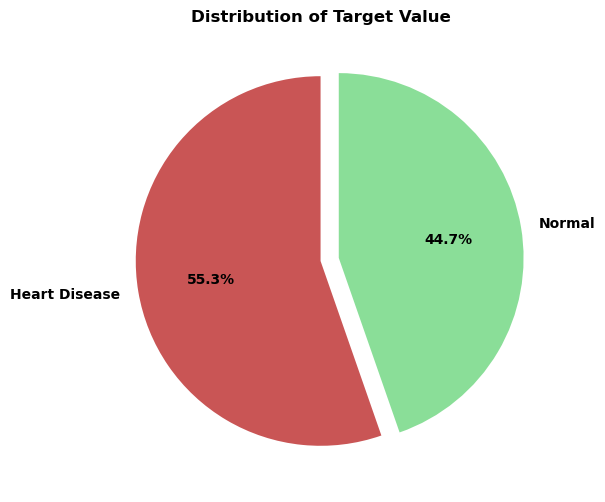

In [9]:
plt.figure(figsize=(8,6),dpi=100)
labels = people_dict.keys()
sizes = people_dict.values()
colors = ["#C95555", "#8ADE98"]
explode = (0, 0.1)
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False,colors=colors, startangle=90, textprops={'fontsize': 10, "fontweight" : "bold"})
plt.title("Distribution of Target Value", size=12, fontweight="bold")

In [10]:
df = pd.read_csv("heart.csv", header=None)
df_cleaned = df.iloc[1:, :]
data = df_cleaned.values
x = data[:, :-1]  
y = data[:, -1] 

In [11]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.3,shuffle=True,random_state=42)

# 1 Decision Tree Classifier

In [12]:
# Function to calculate Gini Impurity
def gini_impurity(groups, classes):
    total_samples = float(sum([len(group) for group in groups]))
    gini = 0.0
    for group in groups:
        size = float(len(group))
        if size == 0:
            continue
        score = 0.0
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        gini += (1.0 - score) * (size / total_samples)
    return gini

In [13]:
# Function to split dataset on an attribute and a value
def test_split(index, value, dataset):
    left, right = [], []
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

In [14]:
# Function to choose the best split
def get_best_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    best_index, best_value, best_score, best_groups = 999, 999, 999, None
    for index in range(len(dataset[0]) - 1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_impurity(groups, class_values)
            if gini < best_score:
                best_index, best_value, best_score, best_groups = index, row[index], gini, groups
    return {'index': best_index, 'value': best_value, 'groups': best_groups}

In [15]:
# Function to create a terminal node (leaf)
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

In [16]:
# Recursive function to split a node
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_best_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_best_split(right)
        split(node['right'], max_depth, min_size, depth+1)

In [17]:
# Function to build a decision tree
def build_tree(train, max_depth, min_size):
    root = get_best_split(train)
    split(root, max_depth, min_size, 1)
    return root

In [18]:
# Function to make predictions with the decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

In [19]:
# Combine x_train and y_train into a single dataset
train_data = np.column_stack((x_train, y_train))

# Build the decision tree using the training data
tree = build_tree(train_data.tolist(), max_depth=5, min_size=10)
print(tree)
print("\n")

{'index': 10, 'value': 'Up', 'left': {'index': 2, 'value': 'ATA', 'left': {'index': 1, 'value': 'M', 'left': {'index': 3, 'value': '132', 'left': {'index': 7, 'value': '123', 'left': '0', 'right': '1'}, 'right': {'index': 9, 'value': '1', 'left': '1', 'right': '1'}}, 'right': {'index': 4, 'value': '171', 'left': {'index': 10, 'value': 'Flat', 'left': '1', 'right': '1'}, 'right': {'index': 4, 'value': '173', 'left': '0', 'right': '1'}}}, 'right': {'index': 1, 'value': 'M', 'left': {'index': 4, 'value': '279', 'left': {'index': 3, 'value': '160', 'left': '0', 'right': '1'}, 'right': '1'}, 'right': {'index': 7, 'value': '137', 'left': {'index': 8, 'value': 'Y', 'left': '1', 'right': '1'}, 'right': {'index': 9, 'value': '0.2', 'left': '1', 'right': '0'}}}}, 'right': {'index': 9, 'value': '1.3', 'left': {'index': 2, 'value': 'ATA', 'left': {'index': 0, 'value': '58', 'left': {'index': 4, 'value': '129', 'left': '1', 'right': '0'}, 'right': {'index': 6, 'value': 'ST', 'left': '1', 'right': '

In [20]:
# Convert x_test to list of lists if needed
if isinstance(x_test, np.ndarray):
    x_test = x_test.tolist()

# Make predictions on the test set
def make_predictions(tree, x_test):
    predictions = []
    for row in x_test:
        prediction = predict(tree, row)
        predictions.append(prediction)
    return predictions

# Predict on the test data
y_pred = make_predictions(tree, x_test)
print(y_pred)


['0', '1', '1', '1', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '1', '1', '0', '0', '1', '1', '0', '1', '0', '0', '1', '0', '0', '1', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '1', '1', '1', '0', '0', '1', '1', '0', '0', '0', '1', '0', '1', '1', '0', '0', '1', '0', '1', '1', '1', '1', '1', '1', '0', '1', '1', '0', '1', '0', '0', '0', '0', '1', '1', '1', '0', '1', '1', '0', '1', '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '1', '1', '0', '1', '1', '0', '1', '1', '0', '1', '1', '0', '1', '1', '0', '0', '1', '0', '1', '0', '1', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1', '1', '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '1', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '1', '1', '0', '1', '1', '1', '0', '1', '0', '0', '1', '0', '1', '1', '1', '1', '0', '0', '1', '0', '0', '0', '1', '1',

In [21]:
# Evaluate the performance (using accuracy as an example)
def accuracy(y_true, y_pred):
    correct = sum(y_true == y_pred)
    return correct / len(y_true)

# Calculate accuracy
acc = accuracy(y_test, np.array(y_pred))
print(f"Accuracy: {acc * 100:.2f}%")

Accuracy: 84.06%


In [22]:
import matplotlib.pyplot as plt
import numpy as np

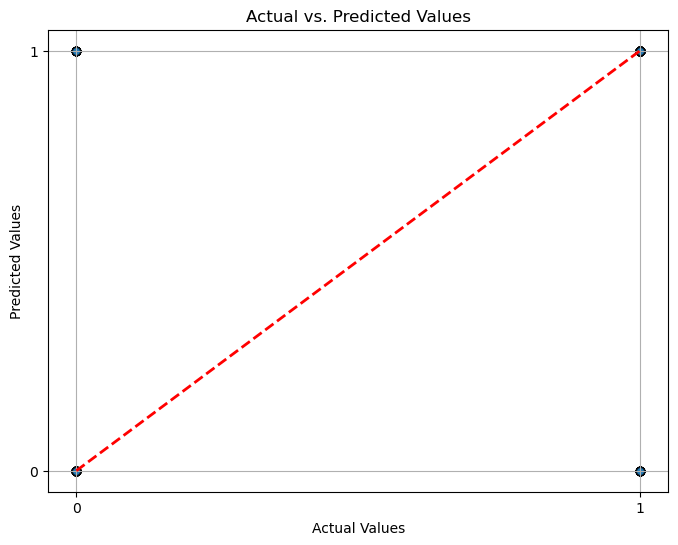

In [23]:
# Scatter plot for actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.grid(True)
plt.show()

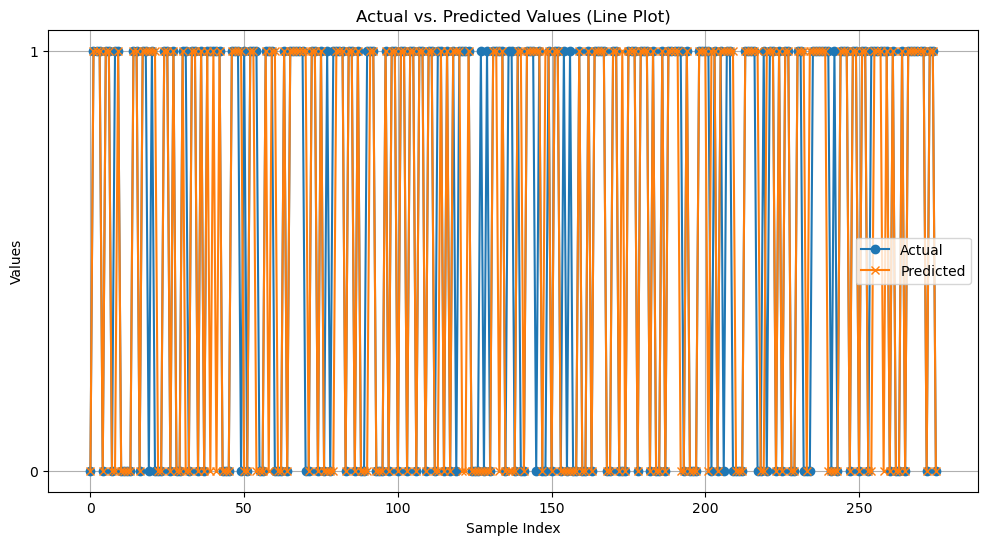

In [24]:
# Line plot for actual vs. predicted values (optional for sequence comparison)
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test)), y_test, label='Actual', marker='o')
plt.plot(np.arange(len(y_pred)), y_pred, label='Predicted', marker='x')
plt.xlabel("Sample Index")
plt.ylabel("Values")
plt.title("Actual vs. Predicted Values (Line Plot)")
plt.legend()
plt.grid(True)
plt.show()

# Add ANN

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [36]:
data = pd.read_csv('heart.csv') 

In [37]:
# Check for non-numeric columns
non_numeric_columns = data.select_dtypes(include=['object']).columns
print(f"Non-numeric columns: {non_numeric_columns}")

Non-numeric columns: Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


In [38]:
# Encode non-numeric columns using LabelEncoder
for col in non_numeric_columns:
    encoder = LabelEncoder()
    data[col] = encoder.fit_transform(data[col])

In [39]:
# Features and target
X = data.iloc[:, :-1].values  # Features (all columns except the last)
y = data.iloc[:, -1].values   # Target (last column)

In [40]:
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [41]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# Step 3: Build the ANN
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer with 16 neurons
    Dense(8, activation='relu'),                                   # Hidden layer with 8 neurons
    Dense(1, activation='sigmoid')                                # Output layer (binary classification)
])

C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [43]:
# Step 4: Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
# Step 5: Train the Model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6081 - loss: 0.6358 - val_accuracy: 0.6395 - val_loss: 0.6043
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6571 - loss: 0.5989 - val_accuracy: 0.7007 - val_loss: 0.5565
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7827 - loss: 0.5174 - val_accuracy: 0.7347 - val_loss: 0.5188
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8002 - loss: 0.4821 - val_accuracy: 0.7687 - val_loss: 0.4881
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8325 - loss: 0.4499 - val_accuracy: 0.7823 - val_loss: 0.4638
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8432 - loss: 0.4303 - val_accuracy: 0.7891 - val_loss: 0.4502
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8353 - loss: 0.4136 - val_accuracy: 0.8231 - val_loss: 0.4376
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8583 - loss: 0.3941 - val_accuracy: 0.8299 - val_loss

In [45]:
# Step 6: Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8357 - loss: 0.3559 
Test Accuracy: 86.41%


In [46]:
# Predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


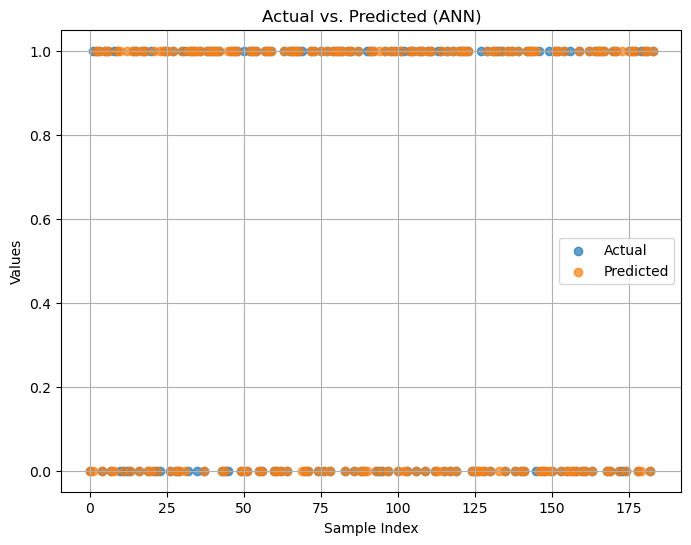

In [47]:
# Visualization of Actual vs. Predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual", alpha=0.7)
plt.scatter(range(len(y_pred)), y_pred, label="Predicted", alpha=0.7)
plt.xlabel("Sample Index")
plt.ylabel("Values")
plt.title("Actual vs. Predicted (ANN)")
plt.legend()
plt.grid(True)
plt.show()

# Adding Optimizers to Your ANN

In [67]:
from tensorflow.keras.optimizers import SGD, Adam

In [69]:
# Example 1: SGD Optimizer
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9)

In [70]:
# Example 2: Adam Optimizer (default settings)
adam_optimizer = Adam(learning_rate=0.001)

In [71]:
# Compile the model with the chosen optimizer
model.compile(optimizer=adam_optimizer,  # Replace with any optimizer (e.g., sgd_optimizer)
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [72]:
# Train the model as before
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9351 - loss: 0.1469 - val_accuracy: 0.8367 - val_loss: 0.5316
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9514 - loss: 0.1412 - val_accuracy: 0.8367 - val_loss: 0.5290
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9440 - loss: 0.1678 - val_accuracy: 0.8231 - val_loss: 0.5380
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9468 - loss: 0.1385 - val_accuracy: 0.8435 - val_loss: 0.5251
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9448 - loss: 0.1547 - val_accuracy: 0.8299 - val_loss: 0.5322
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9425 - loss: 0.1454 - val_accuracy: 0.8435 - val_loss: 0.5283
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9578 - loss: 0.1333 - val_accuracy: 0.8435 - val_loss: 0.5321
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9284 - loss: 0.1681 - val_accuracy: 0.8435 - val_loss

In [73]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
# heigest accuracy

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8587 - loss: 0.5104 
Test Accuracy: 88.04%


In [74]:
# Predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


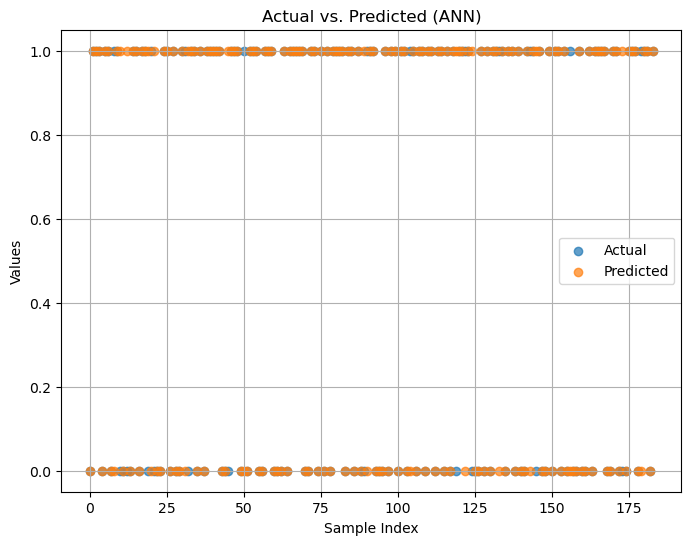

In [75]:
# Visualization of Actual vs. Predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual", alpha=0.7)
plt.scatter(range(len(y_pred)), y_pred, label="Predicted", alpha=0.7)
plt.xlabel("Sample Index")
plt.ylabel("Values")
plt.title("Actual vs. Predicted (ANN)")
plt.legend()
plt.grid(True)
plt.show()

In [76]:
# Compile the model with the chosen optimizer
model.compile(optimizer=sgd_optimizer,  # Replace with any optimizer (e.g., sgd_optimizer)
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [77]:
# Train the model as before
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=64, verbose=1)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9497 - loss: 0.1376 - val_accuracy: 0.8435 - val_loss: 0.5802
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9581 - loss: 0.1239 - val_accuracy: 0.8231 - val_loss: 0.5860
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9536 - loss: 0.1339 - val_accuracy: 0.8367 - val_loss: 0.5704
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9567 - loss: 0.1243 - val_accuracy: 0.8367 - val_loss: 0.5769
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9615 - loss: 0.1188 - val_accuracy: 0.8367 - val_loss: 0.5940
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9641 - loss: 0.1182 - val_accuracy: 0.8435 - val_loss: 0.5692
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9504 - loss: 0.1298 - val_accuracy: 0.8299 - val_loss: 0.6104
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9504 - loss: 0.1339 - val_accuracy: 0.8435 - val_loss

In [79]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8397 - loss: 0.5942 
Test Accuracy: 86.96%
